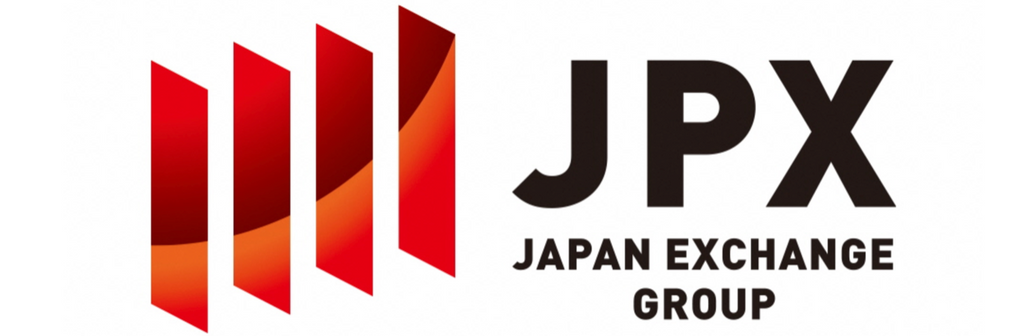

<span style="font-size:18px;"><span style="font-family:cursive;">
  <b>Author: Vincent Weimer <br>
      Date: 2022-05-08</b>
    </span>
  
<hr></hr> 

In [ ]:
%%capture

## Import Libraries
import numpy as np # linear algebra
from numpy.random import seed 
import math 

from scipy.stats import norm
from scipy.stats import normaltest

import pandas as pd # data processing 
pd.options.display.max_rows = 1000
pd.options.display.max_seq_items = 2000
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mpl_dates
plt.rcParams.update({'font.size': 14})
import seaborn as sns
plt.style.use('seaborn')
sns.set_style('whitegrid')

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

import statsmodels as sm
import joblib

In [ ]:
## Helper Methods

def get_stock(df, code):
    return df.query("SecuritiesCode == @code")

def get_stats_on_splits(df):
    affected = df.query('AdjustmentFactor != 1.00')
    num_splits = len(affected)
    num_stocks_affected = affected.SecuritiesCode.nunique()
    num_stocks_more_than_one_split = len(affected.groupby('SecuritiesCode')['AdjustmentFactor'].count().pipe(lambda x: x.loc[x>1]))

    print(f"Total number of stock splits: {num_splits}")
    print(f"Number of affected stocks due to stock splits: {num_stocks_affected}")
    print(f"Number of affected stocks with more than 1 stock split event: {num_stocks_more_than_one_split}")
    
def plot_close(df):
    MA_50 = 'MA_50'
    MA_100 = 'MA_100'
    MA_200 = 'MA_200'
    name = df.iloc[0, 2]
    
    df[MA_50] = df['Adj_Close'].rolling(50).mean()
    df[MA_100] = df['Adj_Close'].rolling(100).mean()
    df[MA_200] = df['Adj_Close'].rolling(200).mean()
    df[[MA_50, MA_100, MA_200, 'Adj_Close']].plot(label='DAL', figsize=(20,8))
    
    plt.title(f"Daily close prices for {name}.")
    plt.xlabel("Date")
    plt.ylabel("Price")
    
    df.drop(columns=[MA_50, MA_100, MA_200])
    
# Parallel df groupby func
def apply_parallel(grouped_df, column_name, func):
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in grouped_df])
    return pd.concat(ret_list)

# Exploratory Data Analysis 

## Read Files

In [ ]:
%%time

## Import data
data_folder = "../input/jpx-tokyo-stock-exchange-prediction/"
data_folder_parquet = "../input/ubiquant-parquet/"

def read_datasets(path):
    print('Loading Stock List...')
    stock_list = pd.read_csv(path + "stock_list.csv")
    display(stock_list.head())
    print('Loading Stock Prices ...')
    stock_prices = pd.read_csv(path + "train_files/stock_prices.csv")
    display(stock_prices.head())
    print('Loading Trades file...')
    trades = pd.read_csv(path + "train_files/trades.csv")
    display(trades.head())
    
    return stock_list, stock_prices, trades

stock_list, stock_prices, trades = read_datasets(data_folder)

In [ ]:
stock_list.columns

In [ ]:
stock_prices.describe()

In [ ]:
stock_prices.info()

## Basic Descriptive Stats on Datasets

In [ ]:
## Get basic stats on stock_prices and stock_list

STOCK_LIST = "Securities Master"
STOCK_PRICES = "Stock Prices"
TRADES = "Trades"

def basic_stats(df, df1):
    
    no_rows = len(df.index)
    missing_close = len(df[df['Close'].isna()])
    unique_no_dates = len(df['Date'].unique())
    no_securities = len(df['SecuritiesCode'].unique())
    pct_missing_close = missing_close / no_rows * 100
    stock_industries = df1['Section/Products'].unique()
    top_10_largest_shares = df1.sort_values('MarketCapitalization', ascending=False).head(10)[['Name']]
    min_date, max_date = df['Date'].min(), df['Date'].max()
    
    # dictionary with list object in values
    stats = {
        'Stat' : ['No. of rows', 'Total no. securities', 'Total no. days', 'Start Date', 'End Date', 'No. rows missing Close', 'Percentage missing close', \
                  'Stock Industries', 'Top 10 Largest Stocks by Market Cap'],
        'Value' : [no_rows, no_securities, unique_no_dates, min_date, max_date, missing_close, pct_missing_close, stock_industries, top_10_largest_shares]
    }
    # creating a Dataframe object 
    return pd.DataFrame(stats)
 
print(f"Info for {STOCK_PRICES}")
display(basic_stats(stock_prices, stock_list))
    

## Prepare data sets for analysis

In [ ]:
## Merge Dataframes stock_list and stock_prices to stocks
# Select needed columns and order them 

merge_columns = ['SecuritiesCode', 'Name', 'Section/Products', '17SectorName', 'MarketCapitalization']
order_columns = [0, 1, 2, 12, 13, 14, 15, 3, 4, 5, 6, 7, 8, 9, 10, 11]

def merge_dataframes(df0, df1): 
    merged = pd.merge(df0, df1.loc[:, merge_columns], on='SecuritiesCode')
    merged = merged[[merged.columns[i] for i in order_columns]]
    merged['Date'] = pd.to_datetime(merged['Date'])
    merged = merged.set_index('Date')
    
    return merged
    
stocks = merge_dataframes(stock_prices, stock_list) 
stocks.head()

## Deeper dive in missing close prices

In [ ]:
## Deepdive into missing prices 

# stocks_reset_index = stocks.reset_index()
df_no_prices = stock_prices[stock_prices['Close'].isna()]
no_prices_per_date = df_no_prices['Date'].value_counts().rename_axis('Date') \
                    .sort_values(ascending=False).head(10).to_frame('Count')

display(no_prices_per_date)

In [ ]:
## Verify for 1 Stock , e.g., Sony on date with highest number of missing close prices 

sony = get_stock(stocks, 6758)
sony_missing = sony.query("'2020-09-28' <= Date <= '2020-10-05'")
display(sony_missing)

After having searched on Google for Tokyo Stock Exchange problems for that date, I discovered there was a technical malfunctioning at the exchange, which caused the worst-ever outage for the Tokyo Stock Exchange. Hence, the high missing number of values for that day. See here a link to the article -> https://asia.nikkei.com/Business/Markets/Japan-stock-markets-brought-to-standstill-by-worst-ever-outage

These values can be filled in with forward-filling missing values technique. 

IMPORTANT!! 
Note that the Volume vlue is 0 when Close prices are NaN. With forward fill, this will not be corrected and the 0 will remain. 
This will have a huge impact and will negatively skew generated multi-day features, e.g., multi-day volume features or multi-day VWAP features

We will set Volume to NaN where it's 0 before we do the forward-fill on missing values.

In [ ]:
# Verify on second highest date with missing values 

day_outage = stocks.query("Date == '2017-03-16' & Close.isna()", engine='python')
day_outage.head(20)

In [ ]:
## Zoom in more on ticker 2761 (Toshin Group) for missing values

toshin = get_stock(stocks, 2761)
toshin_missing = toshin.query("'2017-03-10' <= Date <= '2017-03-20'").loc[:, ['SecuritiesCode', 'Name', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target']]
display(toshin_missing)

No real clear reason can be given here why some days are missing for some particular stocks. Perhaps because this the missing dates on 2761 are in the beginning periods of data collection and some are missing. This can be fixed by forward filling the missing values.

## Correct missing prices and incorrect volume values

In [ ]:
%%time 
def correct_missing_values_dataset(df):
    # 1st set volume values to NaN where volume is 0
    df['Volume'] = df['Volume'].replace(0, np.nan)
    
    # 2nd forward-fill missing values
    df = df.fillna(df.groupby('SecuritiesCode').ffill())
    
    # Check if number of rows remained the same
    print(f"Number of rows after filling missing values: {len(df.index)}")
    
    return df
    
stocks = correct_missing_values_dataset(stocks)

In [ ]:
# Verify for Sony if values have been correctly filled (including volume!)
sony_corrected = get_stock(stocks, 6758).query("'2020-09-28' <= Date <= '2020-10-05'")
display(sony_corrected)

Seems good now.

## Plot/Visualize Stocks

In [ ]:
## Plot Sony, Nintendo, Toyota

sony = get_stock(stocks, 6758)
nintendo = get_stock(stocks, 7974)   # 7974
toyota = get_stock(stocks, 7203)     # 7203

# ------------- #

# plot_close(sony)
# plot_close(nintendo)
# plot_close(toyota)
    

The plots for Sony and Nintento look fine, but there's something wrong with the plot for TOYOTA. There's a huge drop in price at the end of 2021, suggesting a stock split might have happened. After some Google queries this is indeed confirmed a 5:1 stock split https://www.wienerborse.at/en/news/vienna-stock-exchange-news/toyota-stock-split-09292021/#:~:text=As%20of%20Wednesday%2C%2029%20September,Toyota%20Motor%20Corp.%20is%20effective.&text=The%20ISIN%20and%20the%20short,and%20must%20be%20placed%20again. 

We must adjust the prices for stocks that have had stock splits

## Deeper dive in stock-splits

In [ ]:
## Verify the stock split for Toyota

# toyota.query("AdjustmentFactor != 1.00").head()
stocks.query("SecuritiesCode == 1407 & AdjustmentFactor != 1.00").head()

In [ ]:
sony.tail()

In [ ]:
%%time
## Validate which and how many stocks are impacted due to stock splits
get_stats_on_splits(stocks)

## Adjust Open/High/Low/Close for splits by using the adjustment factor
## Method is Backward adjusting

def adjust_price(df, column):
    
    all_tickers = df.SecuritiesCode.unique().tolist()
    
    def adjust_prices_for_splits(df_code, column):

        adj_column = 'Adj_' + column

        # Reverse the DataFrame order, sorting by date in descending order
        df_code.sort_index(ascending=False, inplace=True)

        price_col = df_code[column].values
        split_col = df_code['AdjustmentFactor'].values
        adj_price_col = np.zeros(len(df_code.index))
        adj_price_col[0] = price_col[0]

        for i in range(1, len(price_col)):
            adj_price_col[i] = round((adj_price_col[i - 1] + adj_price_col[i - 1] * (((price_col[i] * split_col[i]) - price_col[i - 1]) / price_col[i - 1])), 4)

        df_code[adj_column] = adj_price_col

        # Change the DataFrame order back to dates ascending
        df_code.sort_index(ascending=True, inplace=True)

        return df_code
    
    stocks_adjusted = []
    for i, code in enumerate(all_tickers):
        df_code = df.query("SecuritiesCode == @code")
        stocks_adjusted.append(adjust_prices_for_splits(df_code, column))
        
    df = pd.concat(stocks_adjusted)
    
    return df

stocks = adjust_price(stocks, 'Open')
stocks = adjust_price(stocks, 'High')
stocks = adjust_price(stocks, 'Low')
stocks = adjust_price(stocks, 'Close')
stocks.head()
    

In [ ]:
toyota_adjusted = stocks.query("SecuritiesCode == 7203")
toyota_adjusted.head()

In [ ]:
plot_close(toyota_adjusted)

In [ ]:
toyota_adjusted.tail()